In [1]:
from pint.models import get_model_and_toas, get_model
from pint.utils import pldmnoise_from_dmwavex, find_optimal_nharms
from pint.logging import setup as setup_log

from enterprise.pulsar import Pulsar
from enterprise.signals.parameter import Uniform, Constant, LinearExp
from enterprise.signals.white_signals import MeasurementNoise, EcorrKernelNoise
from enterprise.signals.signal_base import PTA
from enterprise.signals.gp_signals import TimingModel
from enterprise.signals.selections import Selection, by_backend
from enterprise_extensions.blocks import dm_noise_block, red_noise_block

from PTMCMCSampler.PTMCMCSampler import PTSampler

import numpy as np
import corner
from matplotlib import pyplot as plt
from copy import deepcopy

setup_log(level="WARNING")

/home/abhimanyu/miniconda3/envs/pint-noise/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Optional mpi4py package is not installed.  MPI support is not available.


1

In [2]:
m1, t = get_model_and_toas("B1855+09_DMWX_1.par", "B1855+09_NANOGrav_9yv1.tim", planets=True)
m2 = get_model("B1855+09_DMWX_2.par")

In [5]:
m21 = deepcopy(m2)
m21.remove_component("DMWaveX")
for par in m1.free_params:
    if par.startswith("EFAC") or par.startswith("EQUAD") or par.startswith("ECORR"):
        m1[par].frozen = True

nharms, aics = find_optimal_nharms(m21, t, "DMWaveX", nharms_max=20)

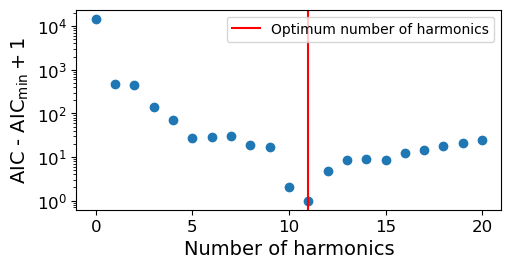

In [6]:
plt.figure(figsize=(5, 2.5))
plt.plot(aics+1, marker="o", ls="")
plt.axvline(nharms, color="red", label="Optimum number of harmonics")
plt.yscale("log")
plt.xlabel("Number of harmonics", fontsize=14)
plt.ylabel("AIC - AIC$_{\\min} + 1$", fontsize=14)
plt.tick_params(labelsize=12)
plt.legend(fontsize=10)
plt.subplots_adjust(bottom=0.19, top=0.99, left=0.14, right=0.99)
plt.savefig("B1855+09-aics.pdf")

In [8]:
psr = Pulsar(m2, t)

In [9]:
wn = MeasurementNoise(efac=Uniform(0.5, 2.0), log10_t2equad=LinearExp(-9, -4), selection=Selection(by_backend))
ec = EcorrKernelNoise(log10_ecorr=LinearExp(-9, -4), selection=Selection(by_backend))
dmn = dm_noise_block(components=11)
arn = red_noise_block(components=1)
tm = TimingModel()

In [10]:
signal = tm + wn + ec + dmn + arn

In [11]:
pta = PTA([signal(psr)])

In [16]:
pta._signalcollections[0].signals[4]

<Enterprise Signal object red_noise[B1855+09_red_noise_log10_A, B1855+09_red_noise_gamma]>

In [17]:
pta._signalcollections[0].signals[1]._params["B1855+09_430_ASP_log10_t2equad"] = Constant(-20)("B1855+09_430_ASP_log10_t2equad")
# pta._signalcollections[0].signals[2]._params["B1855+09_430_ASP_log10_ecorr"] = Constant(-20)("B1855+09_430_ASP_log10_ecorr")
pta._signalcollections[0].signals[1]._params["B1855+09_430_PUPPI_log10_t2equad"] = Constant(-20)("B1855+09_430_PUPPI_log10_t2equad")
# pta._signalcollections[0].signals[2]._params["430_PUPPI_log10_ecorr"] = Constant(-20)("B1855+09_430_PUPPI_log10_ecorr")
# pta._signalcollections[0].signals[3]._params["B1855+09_dm_gp_log10_A"] = Uniform(pmin=-15, pmax=-8)("B1855+09_dm_gp_log10_A")
# pta._signalcollections[0].signals[3]._params["B1855+09_dm_gp_gamma"] = Uniform(pmin=1, pmax=8)("B1855+09_dm_gp_gamma")
pta._signalcollections[0].signals[4]._params["B1855+09_red_noise_gamma"] = Constant(-4)("B1855+09_red_noise_gamma")

In [18]:
pta.params

[B1855+09_430_ASP_efac:Uniform(pmin=0.5, pmax=2.0),
 B1855+09_430_ASP_log10_ecorr:LinearExp(pmin=-9, pmax=-4),
 B1855+09_430_PUPPI_efac:Uniform(pmin=0.5, pmax=2.0),
 B1855+09_430_PUPPI_log10_ecorr:LinearExp(pmin=-9, pmax=-4),
 B1855+09_L-wide_ASP_efac:Uniform(pmin=0.5, pmax=2.0),
 B1855+09_L-wide_ASP_log10_ecorr:LinearExp(pmin=-9, pmax=-4),
 B1855+09_L-wide_ASP_log10_t2equad:LinearExp(pmin=-9, pmax=-4),
 B1855+09_L-wide_PUPPI_efac:Uniform(pmin=0.5, pmax=2.0),
 B1855+09_L-wide_PUPPI_log10_ecorr:LinearExp(pmin=-9, pmax=-4),
 B1855+09_L-wide_PUPPI_log10_t2equad:LinearExp(pmin=-9, pmax=-4),
 B1855+09_dm_gp_gamma:Uniform(pmin=0, pmax=7),
 B1855+09_dm_gp_log10_A:Uniform(pmin=-20, pmax=-11),
 B1855+09_red_noise_log10_A:Uniform(pmin=-20, pmax=-11)]

In [19]:
ndim = len(pta.param_names)
cov = np.diag(np.ones(ndim)) * 1e-4
x0 = np.array([param.sample() for param in pta.params])
Niter = 1000000

In [20]:
print(pta.param_names)

['B1855+09_430_ASP_efac', 'B1855+09_430_ASP_log10_ecorr', 'B1855+09_430_PUPPI_efac', 'B1855+09_430_PUPPI_log10_ecorr', 'B1855+09_L-wide_ASP_efac', 'B1855+09_L-wide_ASP_log10_ecorr', 'B1855+09_L-wide_ASP_log10_t2equad', 'B1855+09_L-wide_PUPPI_efac', 'B1855+09_L-wide_PUPPI_log10_ecorr', 'B1855+09_L-wide_PUPPI_log10_t2equad', 'B1855+09_dm_gp_gamma', 'B1855+09_dm_gp_log10_A', 'B1855+09_red_noise_log10_A']


In [23]:
sampler = PTSampler(
    ndim,
    pta.get_lnlikelihood,
    pta.get_lnprior,
    cov,
    outDir="chains/B1855+09/",
    resume=False
)

In [24]:
sampler.sample(
    x0,
    Niter,
    DEweight=40
)

Finished 1.00 percent in 199.754930 s Acceptance rate = 0.256456Adding DE jump with weight 40
Finished 100.00 percent in 28735.002007 s Acceptance rate = 0.263242
Run Complete


In [542]:
chain = np.genfromtxt(f"chains/B1855+09/chain_1.txt")
burn = chain.shape[0]//5
burned_chain = chain[burn:, :-4]

burned_chain[:,1] = 10**burned_chain[:,1] * 1e6
burned_chain[:,3] = 10**burned_chain[:,3] * 1e6
burned_chain[:,5] = 10**burned_chain[:,5] * 1e6
burned_chain[:,6] = 10**burned_chain[:,6] * 1e6
burned_chain[:,8] = 10**burned_chain[:,8] * 1e6
burned_chain[:,9] = 10**burned_chain[:,9] * 1e6

In [563]:
m1 = get_model("B1855+09_DMWX_1.par")
m11 = pldmnoise_from_dmwavex(m1)

In [561]:
print(m1)

# Created: 2024-01-18T16:00:07.172821
# PINT_version: 0.9.8+204.g898a33f4.dirty
# User: Abhimanyu Susobhanan (abhimanyu)
# Host: abhimanyu-HP-Envy-x360-2-in-1-Laptop-15-fh0xxx
# OS: Linux-6.2.0-39-generic-x86_64-with-glibc2.35
# Python: 3.10.13 (main, Sep 11 2023, 13:44:35) [GCC 11.2.0]
# Format: pint
PSR                              B1855+09
EPHEM                               DE421
CLK                          TT(BIPM2019)
UNITS                                 TDB
START              53358.7274648294696644
FINISH             56598.8719953607796065
INFO                                   -f
TIMEEPH                              FB90
DILATEFREQ                              N
DMDATA                                  N
NTOA                                 4005
CHI2                   4004.9401634434653
CHI2R                   1.003492899885609
TRES                   1.1870273159170592
LAMBDA                286.863489320448139 0 0.00000001573966900040
BETA                   32.321487727700642 

In [579]:
pars = [
    m1.EFAC2, 
    m1.ECORR2,
    m1.EFAC4, 
    m1.ECORR1, 
    m1.EFAC3, 
    m1.ECORR4,
    m1.EQUAD1, 
    m1.EFAC1, 
    m1.ECORR3, 
    m1.EQUAD2, 
    m11.TNDMGAM,
    m11.TNDMAMP
]

def param_label(par):
    return f"{par.prefix}\n[{par.key_value[0]}]" if hasattr(par, "key") else par.name

labels = list(map(param_label, pars))
labels[-2] = "$\\gamma_{\\text{DM}}$"
labels[-1] = "$\\log_{10} A_{\\text{DM}}$"
print(labels)

true_params = list(map(lambda p: p.quantity.value, pars))
true_errs = list(map(lambda p: p.uncertainty.value, pars))

['EFAC\n[430_ASP]', 'ECORR\n[430_ASP]', 'EFAC\n[430_PUPPI]', 'ECORR\n[430_PUPPI]', 'EFAC\n[L-wide_ASP]', 'ECORR\n[L-wide_ASP]', 'EQUAD\n[L-wide_ASP]', 'EFAC\n[L-wide_PUPPI]', 'ECORR\n[L-wide_PUPPI]', 'EQUAD\n[L-wide_PUPPI]', '$\\gamma_{\\text{DM}}$', '$\\log_{10} A_{\\text{DM}}$']


In [577]:
len(true_params), len(true_errs), ndim

(12, 12, 12)

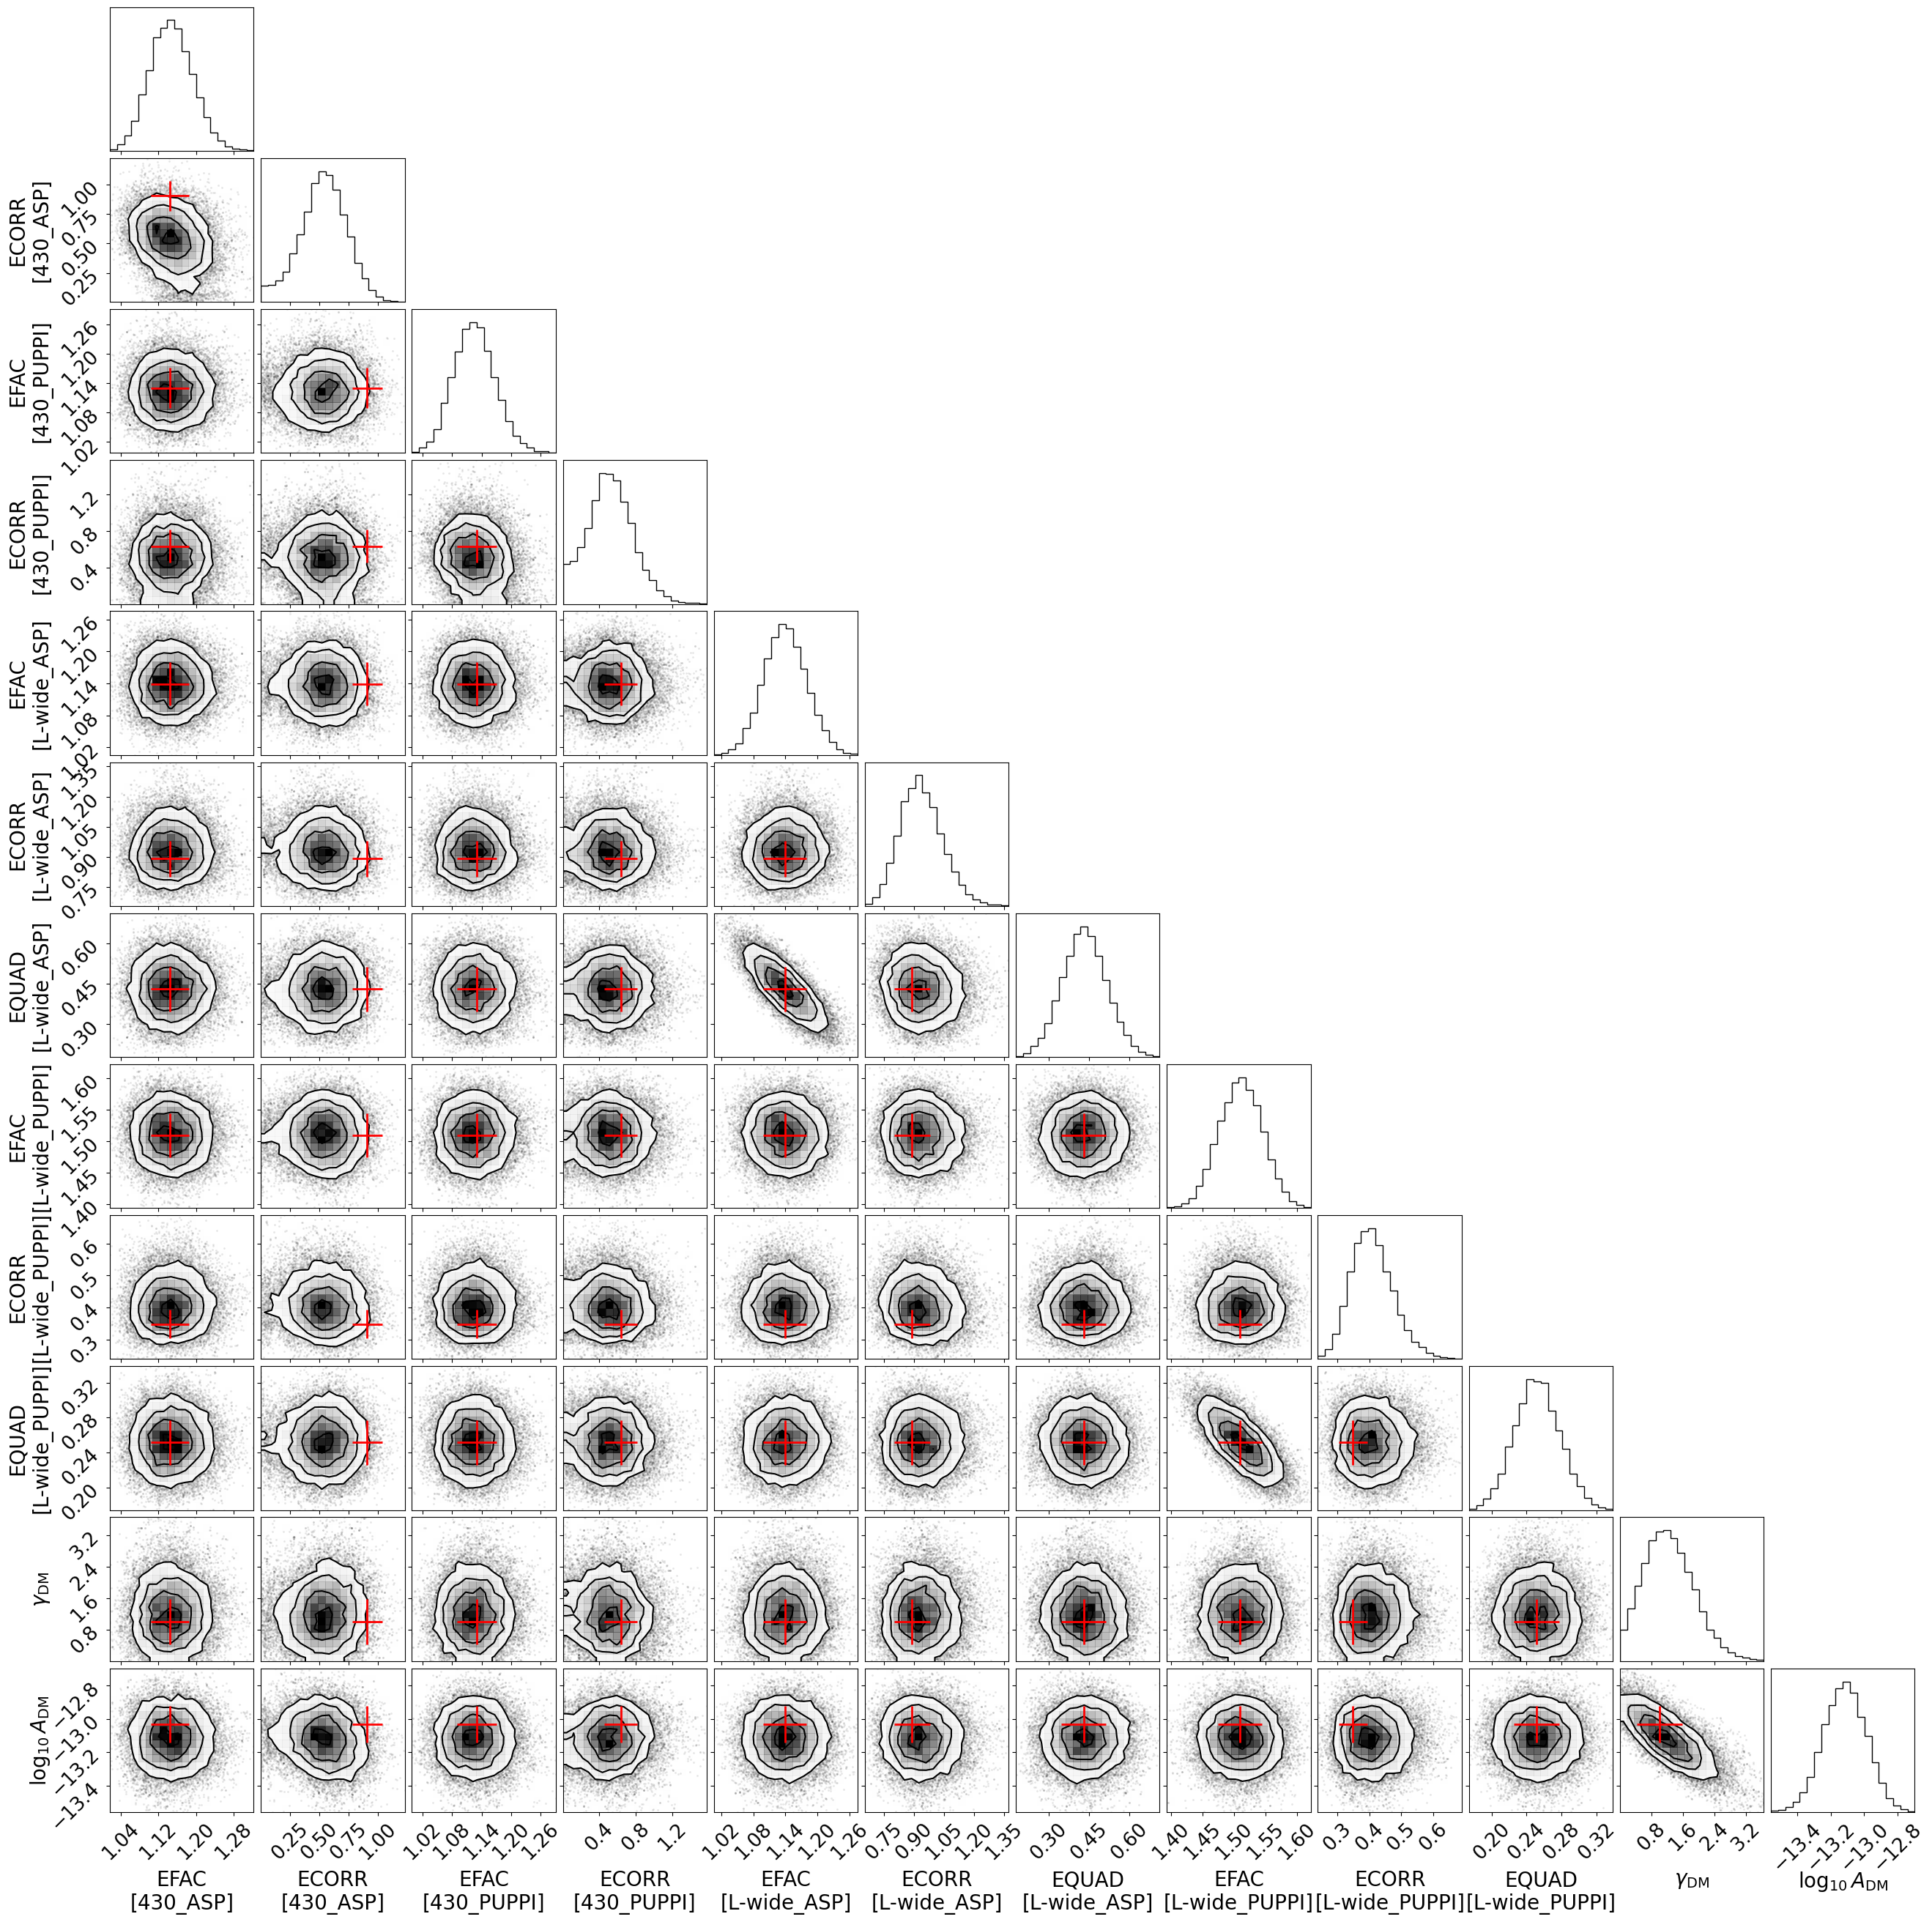

In [582]:
fig = corner.corner(
    burned_chain, 
    labels= labels, #[p[9:] for p in pta.param_names], 
    # truths=true_params,
    range=[0.999]*ndim,
    label_kwargs={"fontsize": 20},
    labelpad=0.1
)

for i in range(ndim):
    x = true_params[i]
    dx = true_errs[i]
    for j in range(i+1, ndim):
        y = true_params[j]
        dy = true_errs[j]
        
        try:
            plt.subplot(ndim, ndim, i + ndim*j + 1)
            plt.errorbar(x=[x], y=[y], xerr=[dx], yerr=[dy], color="red", elinewidth=2)

            plt.tick_params(labelsize=19)
        except:
            print(i, j, )

plt.subplot(ndim, ndim, ndim**2)
plt.tick_params(labelsize=19)

plt.subplots_adjust(left=0.06, bottom=0.06, right=0.99, top=0.99)
plt.savefig("B1855+09-params.pdf")

In [591]:
gamma_e, log10_A_e = np.median(burned_chain, axis=0)[-2:]

In [593]:
m_ent = deepcopy(m11)
m_ent.TNDMAMP.value = log10_A_e
m_ent.TNDMGAM.value = gamma_e
P_ent = m_ent.components["PLDMNoise"].get_noise_weights(t)

In [587]:
from pint import DMconst
from astropy import units as u

scale = DMconst / (1400 * u.MHz)**2
idxs = np.array(m1.components["DMWaveX"].get_indices())
a = np.array([(scale*m1[f"DMWXSIN_{idx:04d}"].quantity).to_value("s") for idx in idxs])
da = np.array([(scale*m1[f"DMWXSIN_{idx:04d}"].uncertainty).to_value("s") for idx in idxs])
b = np.array([(scale*m1[f"DMWXCOS_{idx:04d}"].quantity).to_value("s") for idx in idxs])
db = np.array([(scale*m1[f"DMWXCOS_{idx:04d}"].uncertainty).to_value("s") for idx in idxs])

P = (a**2 + b**2) / 2
dP = ((a*da)**2 + (b*db)**2)**0.5

In [597]:
P_pint = m11.components["PLDMNoise"].get_noise_weights(t)

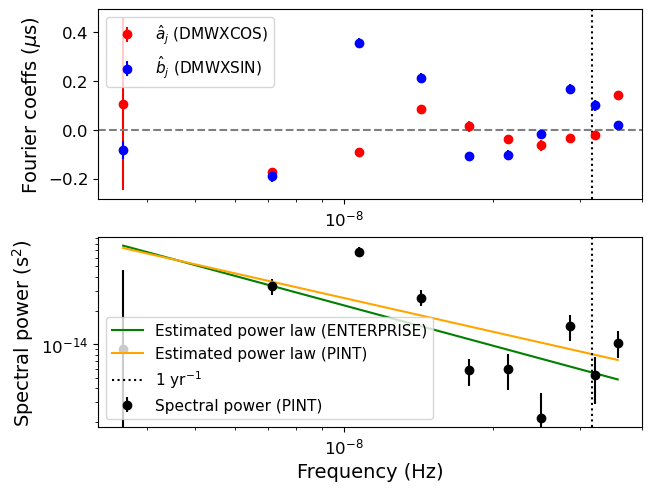

In [609]:
nharm = 10
Tspan = t.get_mjds().max() - t.get_mjds().min()
f0 = (1/Tspan).to_value("Hz")
fyr = (1 / u.year).to_value("Hz")

plt.subplot(211)
plt.errorbar(idxs*f0, b*1e6, db*1e6, ls="", marker="o", label="$\\hat{a}_j$ (DMWXCOS)", color="red")
plt.errorbar(idxs*f0, a*1e6, da*1e6, ls="", marker="o", label="$\\hat{b}_j$ (DMWXSIN)", color="blue")
plt.axvline(fyr, color="black", ls="dotted")
plt.axhline(0, color="grey", ls="--")
plt.ylabel("Fourier coeffs ($\mu$s)", fontsize=14)
plt.xscale("log")
plt.legend(fontsize=11)
plt.tick_params(labelsize=12)

plt.subplot(212)
plt.errorbar(idxs*f0, P, dP, ls="", marker="o", label="Spectral power (PINT)", color="k")
# plt.plot(idxs*f0, P_plrn[::2][:nharm_opt], label="Injected power law")
plt.plot(idxs*f0, P_ent[::2][:nharm], label="Estimated power law (ENTERPRISE)", color="green")
plt.plot(idxs*f0, P_pint[::2][:nharm], label="Estimated power law (PINT)", color="orange")
plt.axvline(fyr, color="black", ls="dotted", label="1 yr$^{-1}$")
plt.xscale("log")
plt.yscale("log")
plt.ylabel("Spectral power (s$^2$)", fontsize=14)
plt.xlabel("Frequency (Hz)", fontsize=14)
plt.legend(fontsize=11)
plt.tick_params(labelsize=12)

plt.subplots_adjust(left=0.14, bottom=0.12, right=0.99, top=0.99)
plt.savefig("B1855+09-spec.pdf")